# Imports

In [3]:
# Test and train file locations
train_path_name = "train.csv"
test_path_name = "test.csv"

import numpy as np
# Data frame
import pandas as pd 
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# Preprocessing
from sklearn.preprocessing import LabelEncoder

train_dataset = pd.read_csv(train_path_name)
test_dataset = pd.read_csv(test_path_name)

# 1. Understanding the problem

<span style="font-size:22px;">  First we have to explore our data, we will start by looking at the data types, the non-null count and there type before going into preprocessing. </span> 

In [4]:
print(f'There are {train_dataset.shape[0]} samples in this dataframe.')
print( train_dataset.info())
print("--------------------------")
print( train_dataset.isnull().sum() )

There are 891 samples in this dataframe.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
--------------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0


<span style="font-size:22px;"> The first things we can note are the fact that PassengerId and Name are both going to be a non effect on the outcome of their survival. Also there is 327 out of 418 missing cabins, too high a % to impute so will will drop the attribue altogher, but there is only 86 ages and 1 fare missing so we will be able to impute them.   </span> 

In [5]:
# Dropping cabin, name and passengerId
train_dataset = train_dataset.drop(columns = ["Cabin", "Name", "PassengerId", "Ticket"])
# Looking at age metrics
train_dataset["Age"].describe().T

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [6]:
train_dataset["Age"] = train_dataset["Age"].fillna(train_dataset["Age"].median())
train_dataset["Embarked"] = train_dataset["Embarked"].fillna(train_dataset["Embarked"].mode()[0])

In [7]:
print(train_dataset["Fare"].describe())
train_dataset["Fare"] = train_dataset["Fare"].fillna(train_dataset["Fare"].mean())

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


In [8]:
train_dataset.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# 2. Label encoding

We will first encode our sexes using label encoding, 0 for male and 1 for female.

In [9]:
# Label encode sexes
labelenoder = LabelEncoder()
train_dataset["Sex"] = labelenoder.fit_transform(train_dataset["Sex"])

Next we will hot encode our Embarked locations using pandas get_dummies function.

In [10]:
# Hot encode cabins
train_dataset = pd.get_dummies(train_dataset, columns = ["Embarked"], drop_first = True)

# 3. EDA

We will now visulise the the distributions of our attributes and their effect on the survival chance.

## Overall

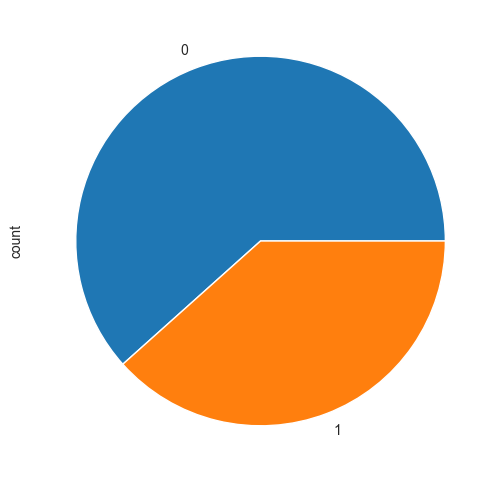

In [11]:
plt.figure(figsize = (8,6))
train_dataset["Survived"].value_counts().plot(kind = "pie")
plt.show()

## Age

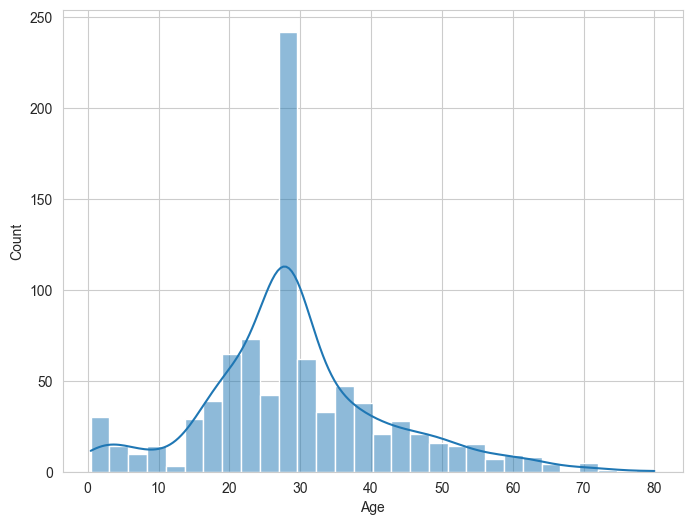

In [12]:
age_par = train_dataset["Age"]

plt.figure(figsize = (8, 6))
sns.histplot(age_par, kde = True)
plt.show()

## Sex

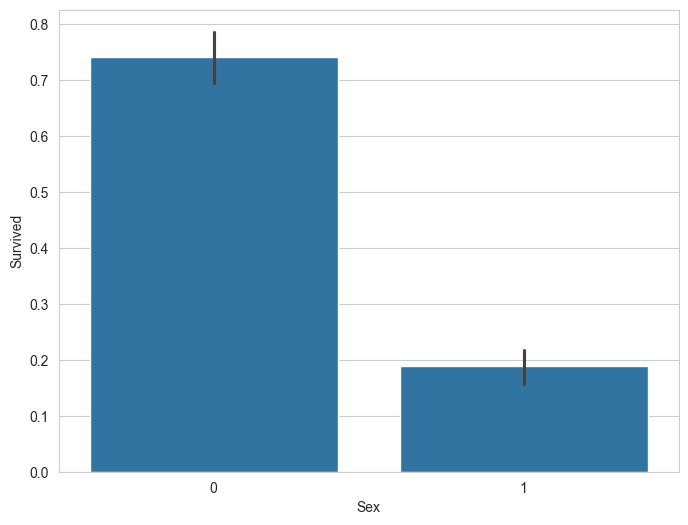

In [13]:
plt.figure(figsize = (8,6))
sns.barplot(x = "Sex", y="Survived", data = train_dataset)
plt.show()

## Fare

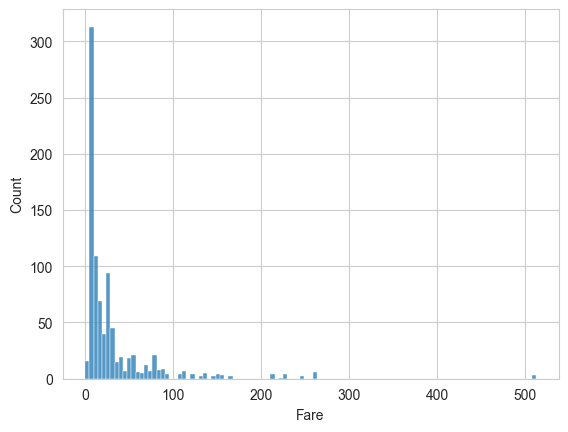

0       7.2500
1      71.2833
2       7.9250
3      53.1000
4       8.0500
        ...   
886    13.0000
887    30.0000
888    23.4500
889    30.0000
890     7.7500
Name: Fare, Length: 891, dtype: float64


In [34]:
from sklearn.preprocessing import quantile_transform

plt.figure()
x = train_dataset["Fare"]
sns.histplot(x)

plt.show()
print(x.iloc[: ])


# 4. Feature engineering

We will now look at feature engineering and start by looking at the correlation of features to the survival column.

In [15]:
train_dataset.corr()["Survived"]

Survived      1.000000
Pclass       -0.338481
Sex          -0.543351
Age          -0.064910
SibSp        -0.035322
Parch         0.081629
Fare          0.257307
Embarked_Q    0.003650
Embarked_S   -0.149683
Name: Survived, dtype: float64

We can also see this neatly using a heat map and a correlation matrix.

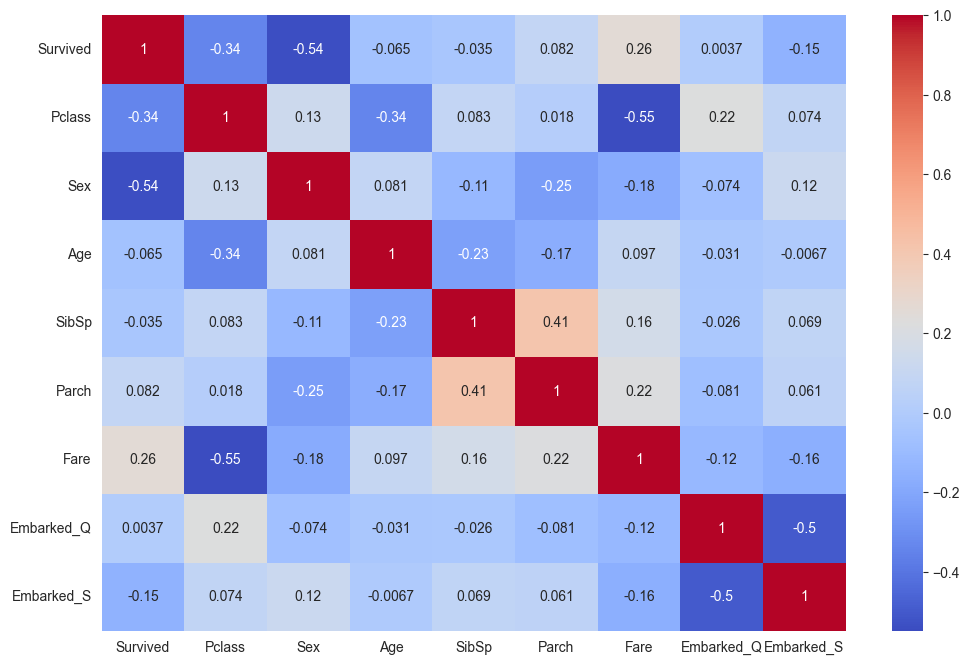

In [16]:
corr_matrix = train_dataset.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Looking along suvvial we see that sibSP, Age and Embarked_Q have very little correlation with surival, we will hence chose to drop sibSp and Age to reduce dimensions, but keep embarked_Q since embarked_S has a small negative correlation with suvival chance.

In [17]:
train_dataset = train_dataset.drop(columns = ["Age", "SibSp"])

# 5 . Choosing targets.

In [18]:
# Creating features and target dataframes
X = train_dataset.drop(columns = ["Survived"])
y = train_dataset["Survived"]

# Splitting data so can use some for model evaluation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.size

4272

# 6. Model fitting and preformance analysis

In [84]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    LinearSVC( C= 0.1, tol=1e-5),
    SVC(kernel = "poly", C = 0.025 , probability=True),
    RandomForestClassifier(n_estimators = 10, max_depth = 10),
    AdaBoostClassifier(),
    DecisionTreeClassifier(max_depth = 10),
    GaussianNB(),
    GradientBoostingClassifier(),
    XGBClassifier(objective = "binary:logistic", n_estimators = 10, seed = 123),
    LGBMClassifier(metric= "binary_logloss")
    
]

In [85]:
# Initialize lists to store results
classifiers_name = []
accuracies = []
sensitivities = []
specificities = []
aucs = []

# Loop through classifiers
for clf in models:
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)

    # Get the name of the classifier
    name = clf.__class__.__name__
    classifiers_name.append(name)  # Store classifier name
    # Make predictions on the test set
    predictions = clf.predict(X_test)

    # Calculate accuracy
    acc = accuracy_score(y_test, predictions)
    accuracies.append(acc)  # Store accuracy

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    sensitivities.append(sensitivity)  # Store sensitivity
    specificities.append(specificity)  # Store specificity

    # Calculate AUC-ROC score
    auc = roc_auc_score(y_test, predictions)
    aucs.append(auc)  # Store AUC

c:\Users\jackg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [86]:
# Create a DataFrame to hold the results
df_results = pd.DataFrame({
    'Classifier': classifiers_name,
    'Accuracy': accuracies,
    'Sensitivity': sensitivities,
    'Specificity': specificities,
    'AUC': aucs
})

# Display the DataFrame
print(df_results.sort_values( by="Accuracy", ascending= False))



                    Classifier  Accuracy  Sensitivity  Specificity       AUC
9                XGBClassifier  0.826816     0.743243     0.885714  0.814479
6       DecisionTreeClassifier  0.815642     0.729730     0.876190  0.802960
10              LGBMClassifier  0.804469     0.702703     0.876190  0.789447
1         KNeighborsClassifier  0.798883     0.702703     0.866667  0.784685
4       RandomForestClassifier  0.793296     0.729730     0.838095  0.783912
8   GradientBoostingClassifier  0.787709     0.675676     0.866667  0.771171
7                   GaussianNB  0.782123     0.729730     0.819048  0.774389
0           LogisticRegression  0.776536     0.743243     0.800000  0.771622
2                    LinearSVC  0.776536     0.689189     0.838095  0.763642
5           AdaBoostClassifier  0.770950     0.729730     0.800000  0.764865
3                          SVC  0.592179     0.027027     0.990476  0.508752
